<a href="https://colab.research.google.com/github/jhchang/Forecasting-Solar-Irradiance/blob/main/05_LSTMforecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Multivariate LSTM for GHI Forecasting

In this notebook, we explore a powerful deep learning approaches for **time series forecasting**: the **Multivariate Long Short-Term Memory (LSTM)** network. This model is designed to capture complex temporal patterns and relationships among multiple correlated features, making them well-suited for our task of forecasting **Global Horizontal Irradiance (GHI)**, a critical variable for solar energy modeling.

### 🔍 What This Notebook Covers:

* ✅ Preparing time series input for multivariate LSTMs
* ✅ Designing and training LSTM architectures on historical GHI and weather features
* ✅ Comparing performance of LSTM against previous benchmarks

### 📊 Dataset & Target

We use a fully featured dataset of \~26,000 hourly records, enriched with:

* Time-based features (e.g., hour, dayofyear)
* Meteorological variables from NASA POWER
* Rolling statistics, lags, and STL decomposition components

Our primary prediction target is `TARGET_1h`, representing the GHI one hour into the future.


In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Replace with your file path
file_path = "/content/drive/MyDrive/datasets/augmented_weather_data.csv"

df = pd.read_csv(file_path, parse_dates=True, index_col=0)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# ---- Feature/Target Split ----
df['TARGET_1h'] = df['ALLSKY_SFC_SW_DWN'].shift(-1) # create target column

# ---- Filter for Daylight Only ----
df = df[df['is_daylight'] == 1].copy()
df = df.dropna()

feature_cols = df.columns.drop(['TARGET_1h'])
target_col = 'TARGET_1h'

X = df[feature_cols]
y = df[target_col]

# ---- Scale Features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Reshape into Sequences for LSTM ----
def create_sequences(X, y, sequence_length=24):  # 24 hours = 2 days of history
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 24
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

## Note: this model did have an additional LSTM(32) and dropout(0.2) layer but it caused the model to predict one value no matter what the timestep

In [ ]:
# ---- Build LSTM Model ----
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.003)  # slight boost

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


# ---- Train ----
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 480.4914 - mae: 480.4914 - val_loss: 463.1956 - val_mae: 463.1956 - learning_rate: 0.0030
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 455.8278 - mae: 455.8278 - val_loss: 441.1316 - val_mae: 441.1316 - learning_rate: 0.0030
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 437.6453 - mae: 437.6453 - val_loss: 420.6076 - val_mae: 420.6076 - learning_rate: 0.0030
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 416.3518 - mae: 416.3518 - val_loss: 400.9035 - val_mae: 400.9035 - learning_rate: 0.0030
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 398.2650 - mae: 398.2650 - val_loss: 382.6913 - val_mae: 382.6913 - learning_rate: 0.0030
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 378.9385 - mae: 378.9385 - val_loss: 366.5544 - val_mae: 366.5544 - learning_rate: 0.0030
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 363.0815 - mae: 363.0815 - val_lo

In [ ]:
# ---- Evaluate ----
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAE: {mae:.2f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM RMSE: 36.39
LSTM MAE: 20.49


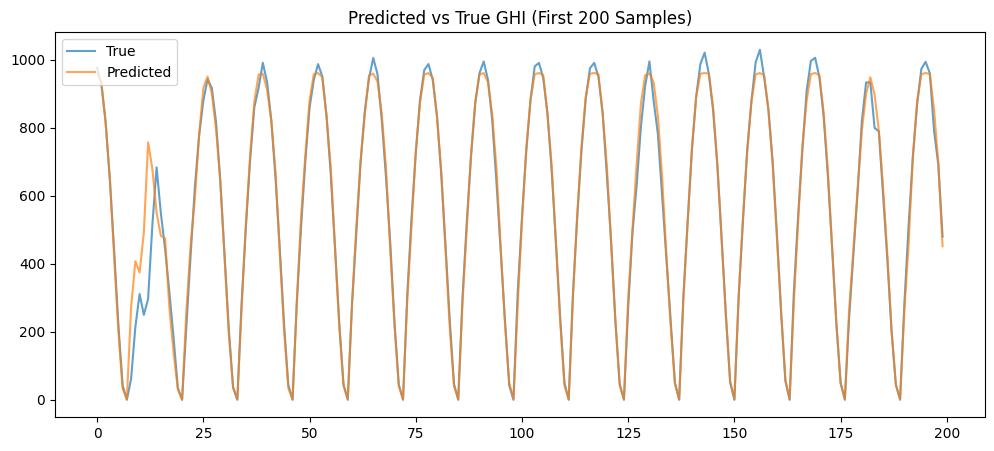

In [ ]:
import matplotlib.pyplot as plt

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(y_test[:200], label='True', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.legend()
plt.title("Predicted vs True GHI (First 200 Samples)")
plt.show()

/tmp/ipython-input-7-3625016644.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, shade=True, color='green')


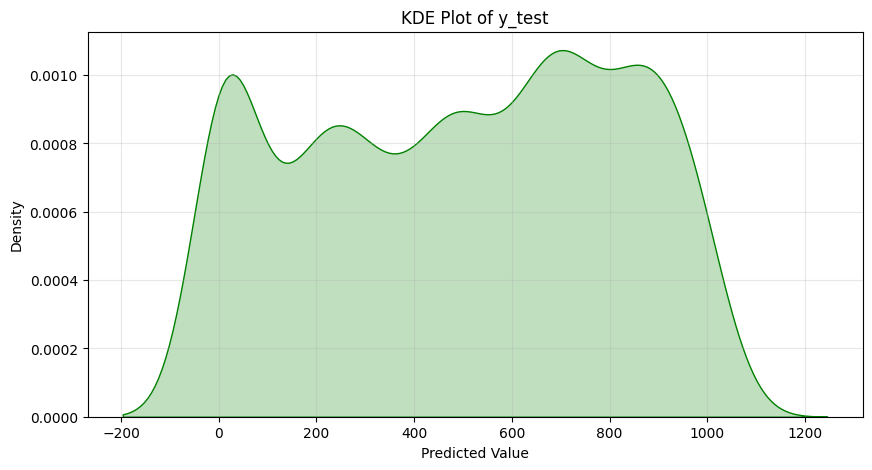

/tmp/ipython-input-7-3625016644.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, shade=True, color='green')


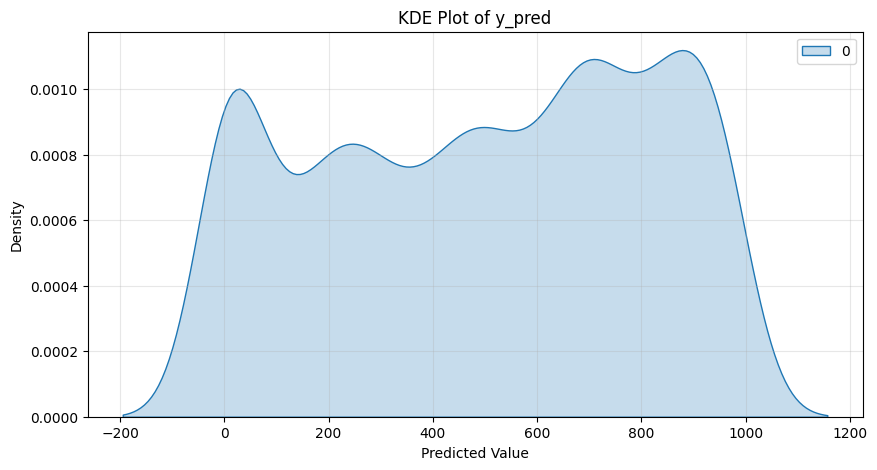

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(y_test, shade=True, color='green')
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('KDE Plot of y_test')
plt.grid(alpha=0.3)
plt.show()
plt.figure(figsize=(10, 5))
sns.kdeplot(y_pred, shade=True, color='green')
plt.xlabel('Predicted Value')
plt.ylabel('Density')
plt.title('KDE Plot of y_pred')
plt.grid(alpha=0.3)
plt.show()

# Testing increasing length of LSTM sequence (48 hours)

In [ ]:
import pandas as pd

# Replace with your file path
file_path = "/content/drive/MyDrive/datasets/augmented_weather_data.csv"

df = pd.read_csv(file_path, parse_dates=True, index_col=0)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# ---- Feature/Target Split ----
df['TARGET_1h'] = df['ALLSKY_SFC_SW_DWN'].shift(-1) # create target column

# ---- Filter for Daylight Only ----
df = df[df['is_daylight'] == 1].copy()
df = df.dropna()

feature_cols = df.columns.drop(['TARGET_1h'])
target_col = 'TARGET_1h'

X = df[feature_cols]
y = df[target_col]

# ---- Scale Features ----
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---- Reshape into Sequences for LSTM ----
def create_sequences(X, y, sequence_length=48):  # 48 hours = 4 days of history
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(X)):
        X_seq.append(X[i-sequence_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 48
X_seq, y_seq = create_sequences(X_scaled, y.values, sequence_length)

# ---- Train/Test Split ----
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

## Note: this model did have an additional LSTM(32) and dropout(0.2) layer but it caused the model to predict one value no matter what the timestep

In [ ]:
# ---- Build LSTM Model ----
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input

model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1)
])


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = Adam(learning_rate=0.003)  # slight boost

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)


# ---- Train ----
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 482.5935 - mae: 482.5935 - val_loss: 462.2117 - val_mae: 462.2117 - learning_rate: 0.0030
Epoch 2/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 457.7521 - mae: 457.7521 - val_loss: 440.7286 - val_mae: 440.7286 - learning_rate: 0.0030
Epoch 3/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 436.8644 - mae: 436.8644 - val_loss: 420.4520 - val_mae: 420.4520 - learning_rate: 0.0030
Epoch 4/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 417.0718 - mae: 417.0718 - val_loss: 401.1191 - val_mae: 401.1191 - learning_rate: 0.0030
Epoch 5/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 401.7787 - mae: 401.7787 - val_loss: 383.0496 - val_mae: 383.0496 - learning_rate: 0.0030
Epoch 6/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 378.0439 - mae: 378.0439 - val_loss: 367.1866 - val_mae: 367.1866 - learning_rate: 0.0030
Epoch 7/100
168/168 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 368.1850 - mae: 368.1850 - val_l

In [ ]:
# ---- Evaluate ----
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"LSTM RMSE: {rmse:.2f}")
print(f"LSTM MAE: {mae:.2f}")

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM RMSE: 37.64
LSTM MAE: 21.28


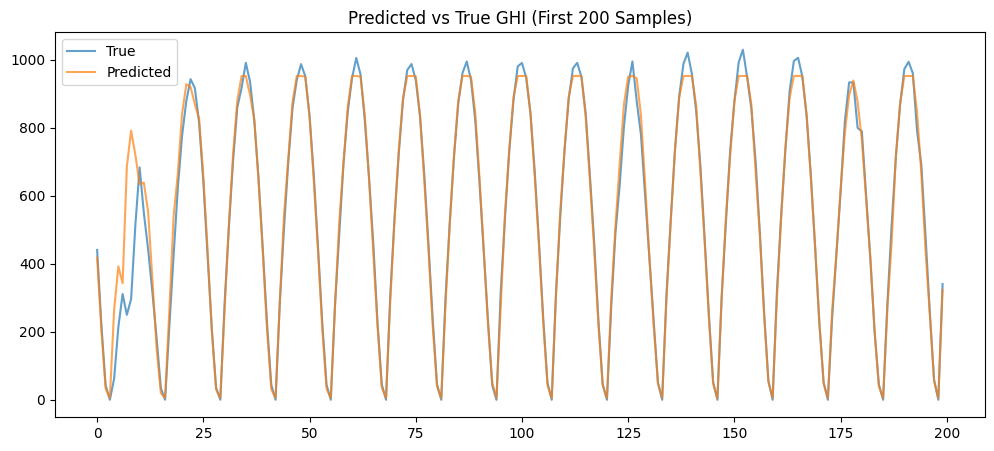

In [ ]:
import matplotlib.pyplot as plt

# --- Plot ---
plt.figure(figsize=(12, 5))
plt.plot(y_test[:200], label='True', alpha=0.7)
plt.plot(y_pred[:200], label='Predicted', alpha=0.7)
plt.legend()
plt.title("Predicted vs True GHI (First 200 Samples)")
plt.show()

# Comparison of Results of sequence length of lstm data
| Sequence Length | RMSE      | MAE       |
| --------------- | --------- | --------- |
| 24 hours        | **37.30** | **21.10** |
| 48 hours        | 37.64     | 21.28     |

It seems like with 4 days of data vs 2 days worth of Data, there seems to be no improvement. This might be the limit of LSTMs. The LSTM already performs very well. Longer sequence ≠ better and in fact, in our: Less is more.


# Conclusion

Let's move on to Temporal Fusion Transformer. We will try out this more complicated model for a number of reasons:

- We want to use state of the art deep ML models
- We want to use a model that can handle long range attention for features and time steps

TFT uses the attention mechanism and is built to handle multi-horizon and calendar-seasonal patterns. Our goal is to capture data in the past and use it to predict weather events in the futuer to model GHI in times of unexpected weather more accurately.